This is the notebook expalaining data preparation process. To be honest I had a hard time with Sentinel-2 APIs and still haven't quite figured out how to work with this. I decided on a different approach for this task. I went to Copernicus site and manually downloaded a photo of a chunk of France

In [ ]:
# @title
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.5 MB/s eta 0:00:00


In [ ]:
# @title
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import cv2
import os
from rasterio.plot import show
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
from skimage.transform import resize
from PIL import Image
import random
from scipy.spatial.distance import cdist

In [ ]:
# @title
summer_path = "/content/T31UDQ_20210614T105031_TCI_10m.jp2"
winter_path = "/content/T31UDQ_20220115T105309_TCI_10m.jp2"

with rasterio.open(summer_path, "r", driver='JP2OpenJPEG') as summ, \
    rasterio.open(winter_path, "r", driver='JP2OpenJPEG') as wint:
    summ_raster = summ.read()
    summ_raster_meta = summ.meta
    wint_raster = wint.read()
    wint_raster_meta = wint.meta


In [ ]:
# @title
print(summ_raster_meta)
print(wint_raster_meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 5500020.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 5500020.0)}


In [ ]:
# @title
raster_summ_img = reshape_as_image(summ_raster)
raster_wint_img = reshape_as_image(wint_raster)

This is a photo of northern France at the middle of june. A large city on the photo is Paris and you can clearly see the river Seine

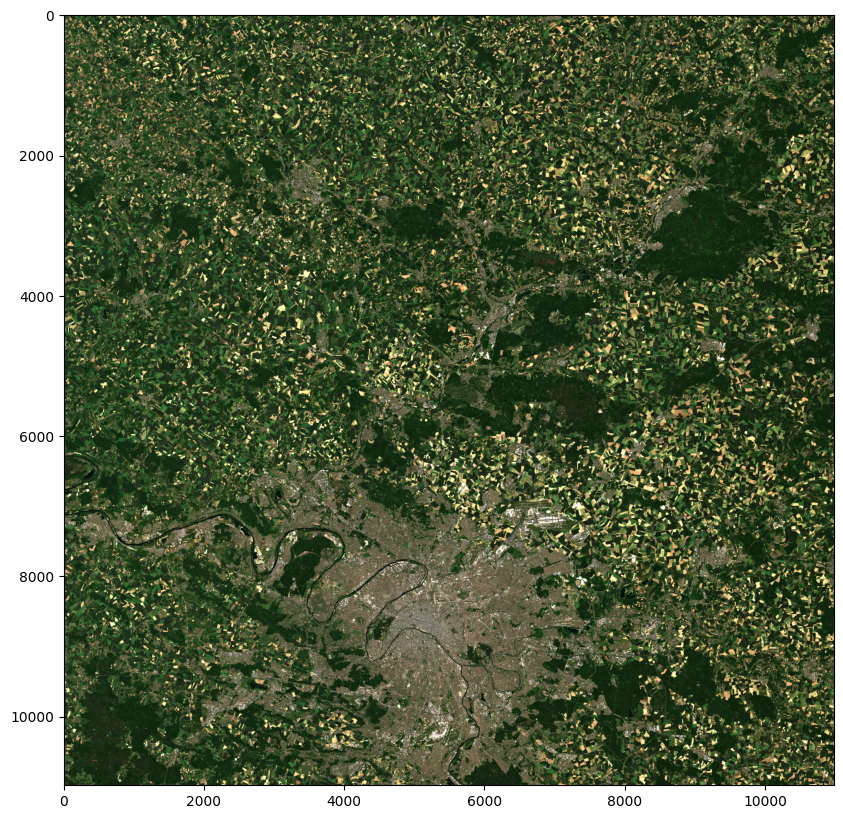

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(raster_summ_img)

And a winter photo

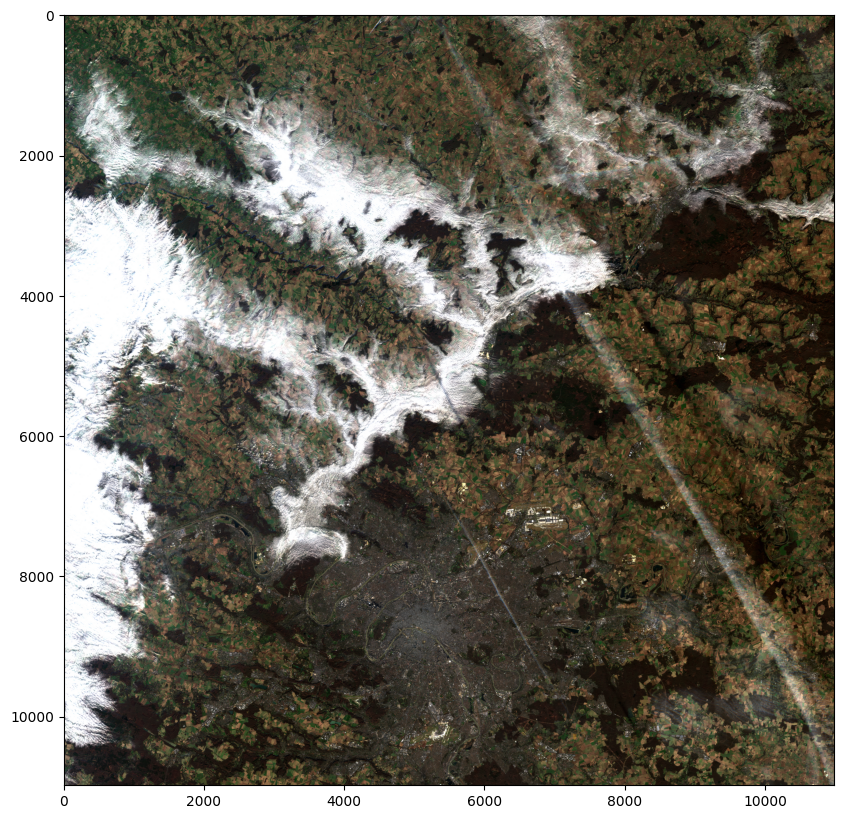

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(raster_wint_img)

As the photos have very high resolution they can be split into smaller photos without loss of quality. If we were to split a 10000x10000 on 256x256 images we would get about 1800 images for each photo, let's try to go with that and see how it goes

In [ ]:
raster_summ_img.shape

(10980, 10980, 3)

Function to split the image

In [ ]:
def split_image(raster_data, output_dir, tile_size):
    # Convert raster data to PIL Image
    if raster_data.ndim == 3:
        height, width, bands = raster_data.shape
        if bands == 3:
            img = Image.fromarray(raster_data, 'RGB')
        elif bands == 4:
            img = Image.fromarray(raster_data, 'RGBA')
        else:
            img = Image.fromarray(raster_data[:,:,0], 'L')
    else:
        img = Image.fromarray(raster_data, 'L')

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Loop through the image and save tiles
    for i in range(0, width, tile_size):
        for j in range(0, height, tile_size):
            # Define the bounding box for the tile
            box = (i, j, min(i + tile_size, width), min(j + tile_size, height))

            # Crop the image to the tile
            tile = img.crop(box)

            # Save the tile
            tile_name = f'tile_{i}_{j}.png'
            tile_path = os.path.join(output_dir, tile_name)
            tile.save(tile_path)

    print(f"Image split into tiles and saved in {output_dir}")


Actual splitting

In [ ]:
output_summ_path = "/content/sample_data/images/summer"
image_path = "/content/T31UDQ_20210614T105031_TCI_10m.jp2"
#print(raster_summ_img)
split_image(raster_summ_img, output_path, 256)

Image split into tiles and saved in /content/sample_data/images/summer


In [ ]:
output_wint_path = "/content/sample_data/images/winter"
image_path = "/content/T31UDQ_20210614T105031_TCI_10m.jp2"
#print(raster_summ_img)
split_image(raster_wint_img, output_wint_path, 256)

Image split into tiles and saved in /content/sample_data/images/winter


Just a code to look if the images are actually split as needed

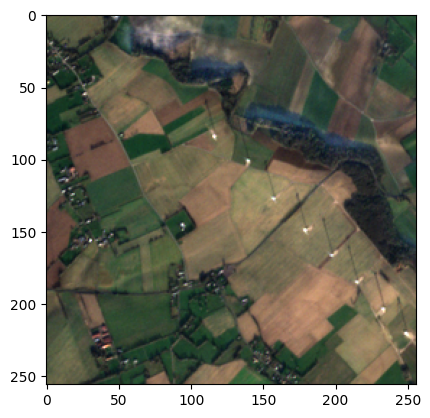

In [ ]:
def view_sample_tiles(output_dir, num_samples=3):
    # Get all PNG files in the directory
    tile_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

    # Randomly select a few tiles
    samples = random.sample(tile_files, min(num_samples, len(tile_files)))

    # Create a subplot for each sample
    fig, axs = plt.subplots(1, len(samples), figsize=(15, 5))
    if len(samples) == 1:
        axs = [axs]

    for ax, sample in zip(axs, samples):
        img = Image.open(os.path.join(output_dir, sample))
        ax.imshow(img)
        ax.set_title(sample)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Our function pretty conviniently gives out the same names to the same chunks of the original image

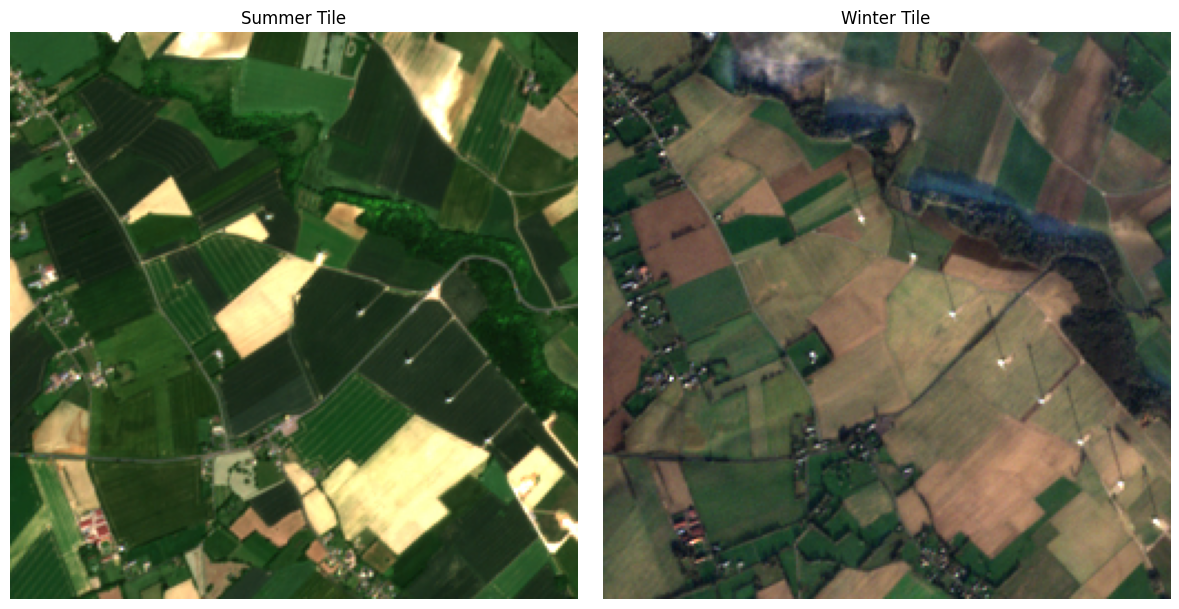

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Load and display the summer image
summer_img = Image.open("/content/sample_data/images/summer/tile_0_1792.png")
ax1.imshow(summer_img)
ax1.set_title("Summer Tile")
ax1.axis('off')  # Hide axis

# Load and display the winter image
winter_img = Image.open("/content/sample_data/images/winter/tile_0_1792.png")
ax2.imshow(winter_img)
ax2.set_title("Winter Tile")
ax2.axis('off')  # Hide axis

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
print(len(os.listdir("/content/sample_data/images/summer")))

1849
